In [6]:
using JLD2
using Printf
using CairoMakie
using FourierFlows
using LinearAlgebra: ldiv!, mul!

include("../../utils/IFMAB3.jl")
include("../../swqg/SWQG.jl")
using .SWQG: streamfunctionfrompv!

In [7]:
data_directory = "/scratch/nad9961/swqg/53531742/6/"

"/scratch/nad9961/swqg/53531742/6/"

In [90]:
qg_snapshots = jldopen(data_directory * "/qgsw.000000.jld2", "r")

params = (Kd2 = qg_snapshots["params/Kd2"], )
grid = TwoDGrid(; Lx=qg_snapshots["grid/Lx"], nx=qg_snapshots["grid/nx"])

frames = keys(qg_snapshots["snapshots/sol"])
idx = 100
t_snap = qg_snapshots["snapshots/t/" * frames[idx]]
qh = qg_snapshots["snapshots/sol/" * frames[idx]]
ψh = zeros(Complex{Float32}, size(qh))
streamfunctionfrompv!(ψh, qh, grid, params)

257×512 Matrix{ComplexF32}:
      -0.0-0.0im       1881.94+557.856im    …   1881.94-557.856im
   925.363-1883.85im  -919.981+5061.79im        3721.68+792.24im
  -769.662+1698.92im  -1999.95-1354.3im        -1558.12+1856.62im
   546.614+242.418im   28.9985-717.615im        -983.41-25.668im
   -969.07-359.585im   422.312-433.204im        256.859-359.608im
   292.414-140.511im   246.917+387.315im    …  -41.7005-394.065im
   164.969-14.7592im  -44.3396-36.312im         49.0303+310.831im
   57.3741+92.6522im  -85.6034+2.51119im        64.1078-103.944im
  -102.879+53.7979im   10.8089-0.0438807im     -68.6567+12.5912im
 -0.154548-24.3952im   34.8468-24.3072im        16.9972+29.1483im
   10.5931-25.4397im  -32.2441-8.83162im    …   5.36338-3.18501im
  0.103062+3.7549im    19.5169+18.659im        -8.99079-10.2817im
   9.02241+5.27178im  -4.25202-11.6517im        1.22961+13.0945im
          ⋮                                 ⋱  
      -0.0-0.0im          -0.0-0.0im        …      -0.0-0.0im
      

In [93]:
# Compute strain and vorticity fields
uh =  -grid.l  .* ψh
vh =   grid.kr .* ψh

uxh =  grid.kr .* uh
uyh =  grid.l  .* uh
vxh =  grid.kr .* vh
vyh =  grid.l  .* vh

Δh  = uxh + vyh
ζh  = vxh - uyh
σnh = uxh - vyh
σsh = vxh + uyh;

Δ = zeros(grid.nx, grid.ny)
ζ = zeros(grid.nx, grid.ny)
σn = zeros(grid.nx, grid.ny)
σs = zeros(grid.nx, grid.ny)

ldiv!(Δ, grid.rfftplan, Δh)
ldiv!(ζ, grid.rfftplan, ζh)
ldiv!(σn, grid.rfftplan, σnh)
ldiv!(σs, grid.rfftplan, σsh);

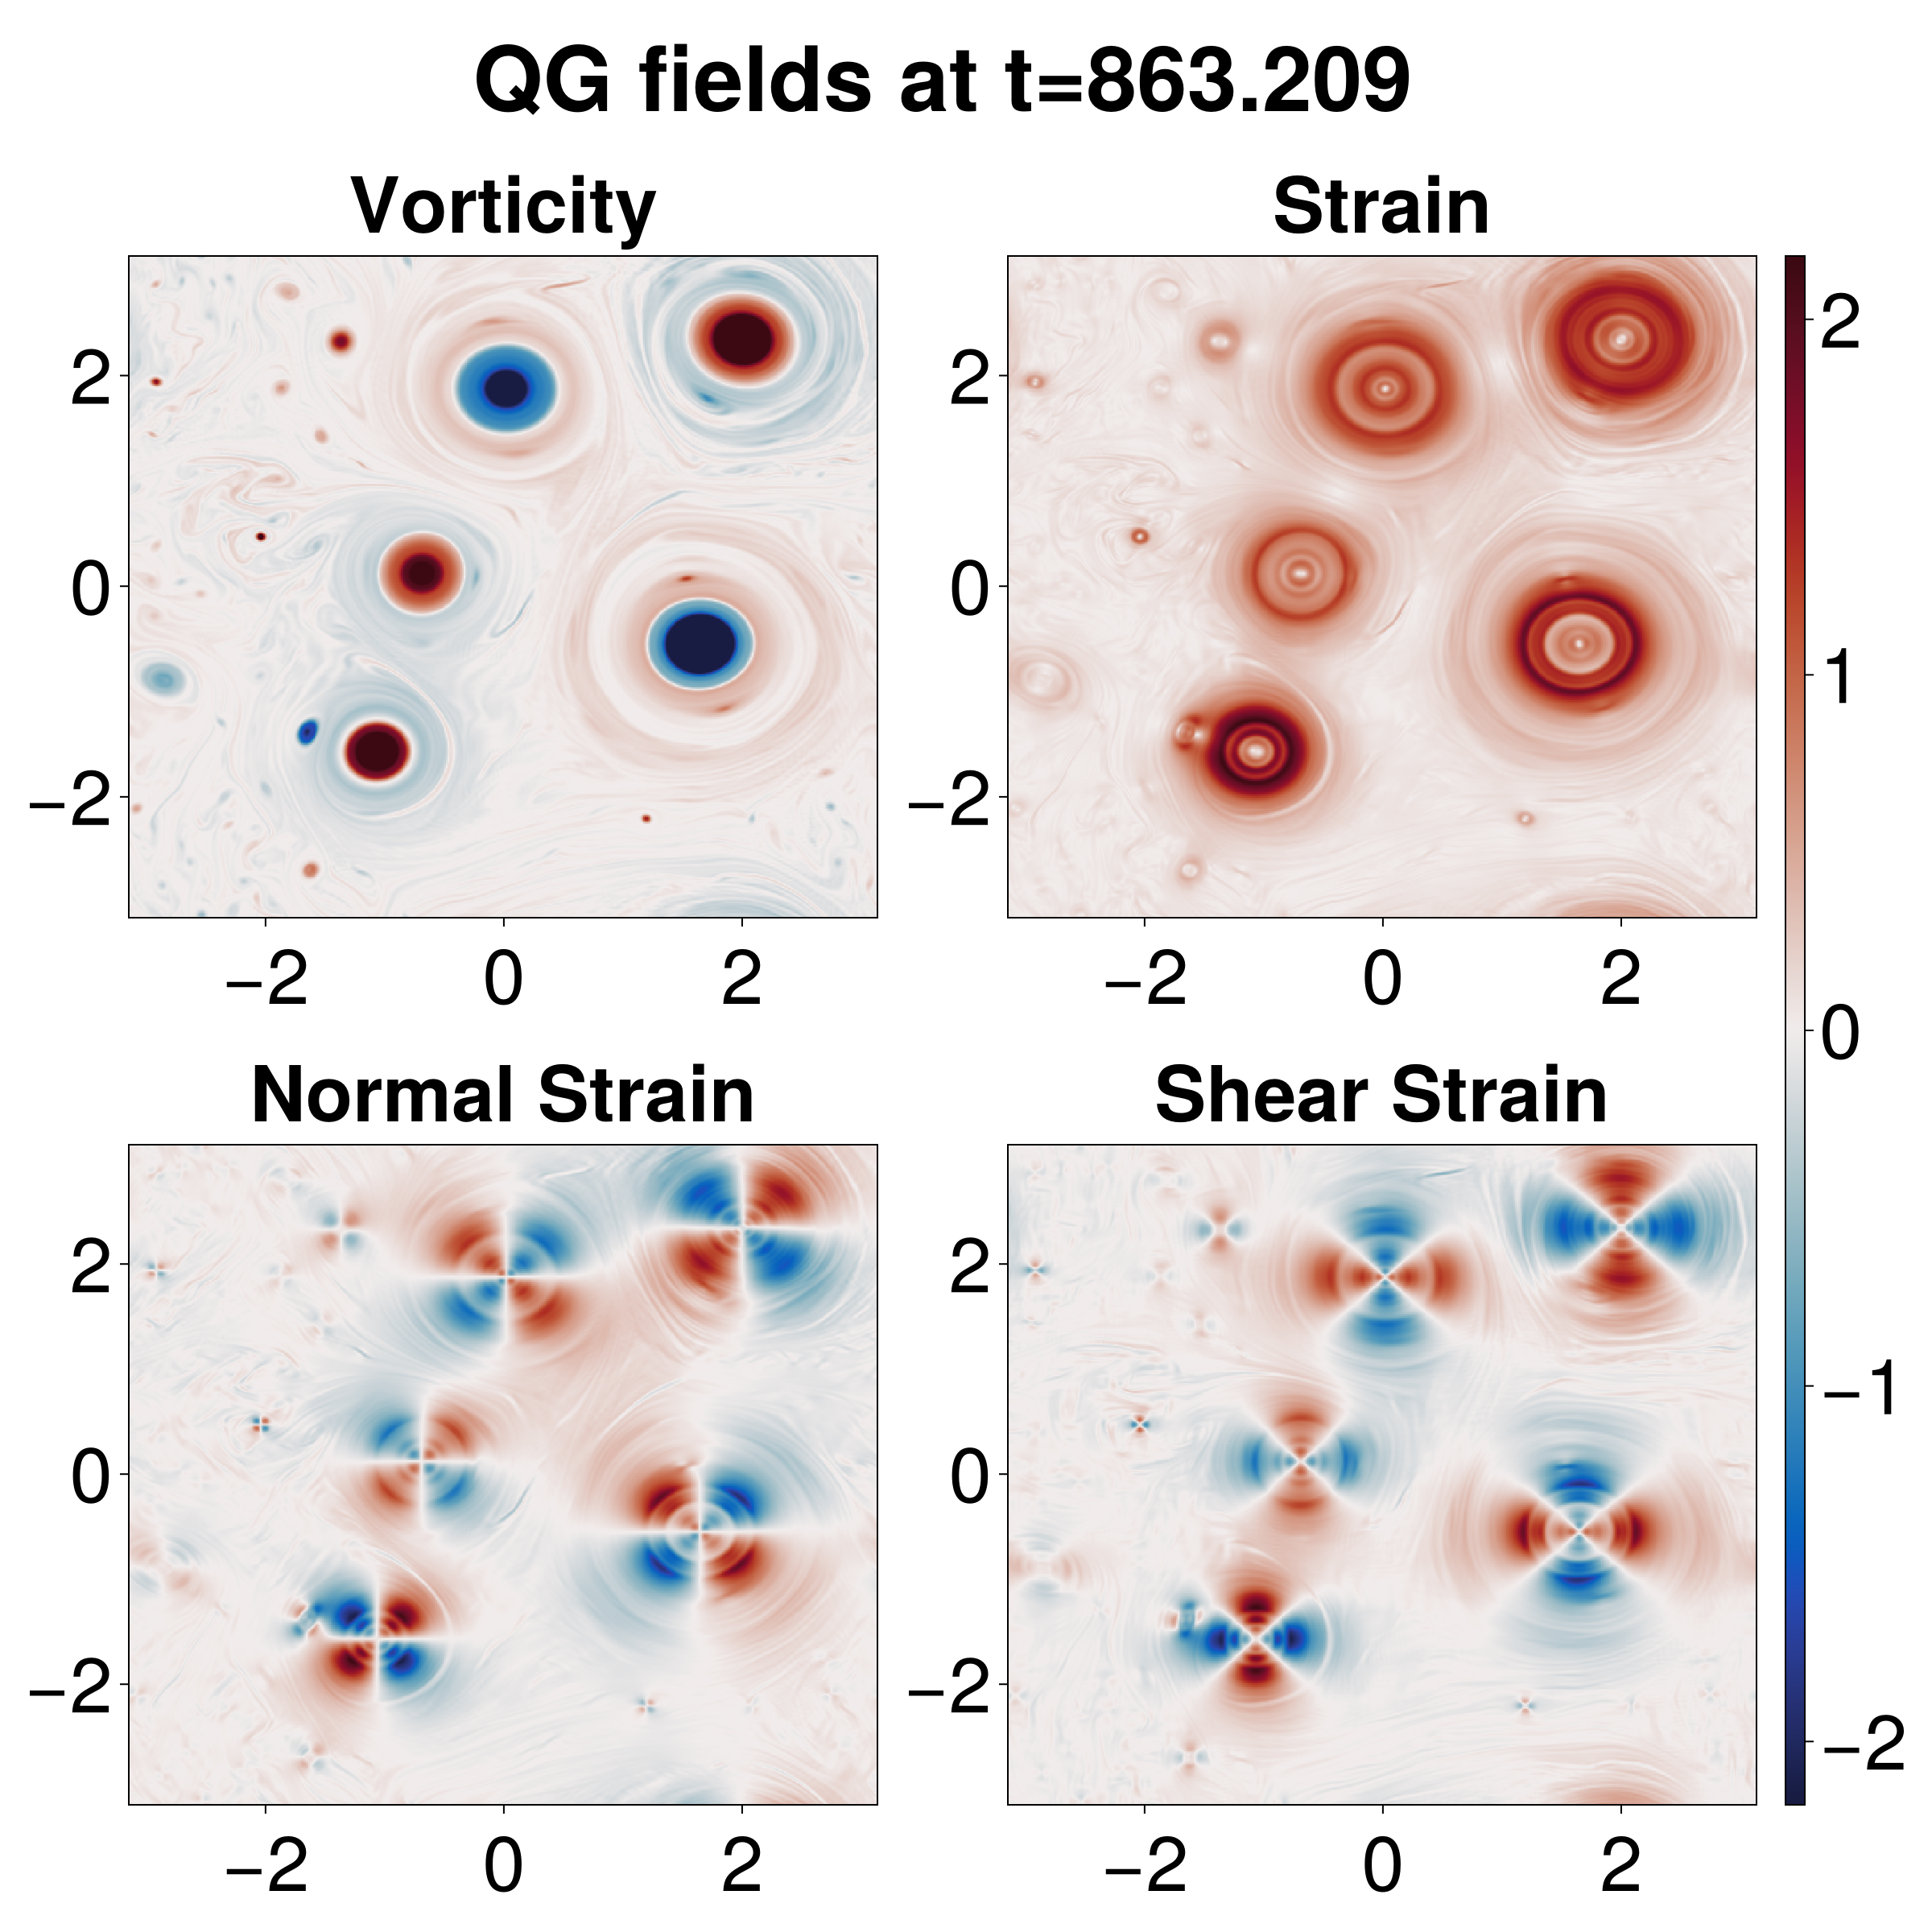

In [94]:
# Create plots of each field
field_fig = Figure(size=(1200, 1200), fontsize=48)
ζ_ax = Axis(field_fig[2,1], title="Vorticity")
σ_ax = Axis(field_fig[2,2], title="Strain")
σn_ax = Axis(field_fig[3,1], title="Normal Strain")
σs_ax = Axis(field_fig[3,2], title="Shear Strain")

σ = @. sqrt(σn^2 + σs^2)
cmax = max(maximum(abs.(σ)), maximum(abs.(σn)), maximum(abs.(σs)))
contour_opts = (colormap=:balance, colorrange=(-cmax, cmax), )

hm = heatmap!(ζ_ax,  grid.x, grid.y, ζ; contour_opts...)
heatmap!(σ_ax,  grid.x, grid.y, σ;  contour_opts...)
heatmap!(σn_ax, grid.x, grid.y, σn; contour_opts...)
heatmap!(σs_ax, grid.x, grid.y, σs; contour_opts...)

cbar = Colorbar(field_fig[2:3,3], hm)
Label(field_fig[1,1:2], @sprintf("QG fields at t=%0.3f", t_snap); fontsize=56, font=:bold)

save(@sprintf("fields_snapshot_idx=%d.png", idx), field_fig)
field_fig

In [52]:
function compute_strain_vorticity(ψh)
    uh =  -grid.l  .* ψh
    vh =   grid.kr .* ψh
    
    uxh =  grid.kr .* uh
    uyh =  grid.l  .* uh
    vxh =  grid.kr .* vh
    vyh =  grid.l  .* vh
    
    ζh  = vxh - uyh
    σnh = uxh - vyh
    σsh = vxh + uyh;
    
    ζ = zeros(grid.nx, grid.ny)
    σn = zeros(grid.nx, grid.ny)
    σs = zeros(grid.nx, grid.ny)
    
    ldiv!(ζ, grid.rfftplan, ζh)
    ldiv!(σn, grid.rfftplan, σnh)
    ldiv!(σs, grid.rfftplan, σsh)
    
    σ = @. sqrt(σn^2 + σs^2)

    return σ, ζ
end

compute_strain_vorticity (generic function with 1 method)

In [55]:
start_idx=2
end_idx=2
Npoints = (end_idx - start_idx + 1) * grid.nx * grid.ny

σ_array = zeros(Npoints)
ζ_array = zeros(Npoints)
step_size = grid.nx * grid.ny
for frame_idx=start_idx:end_idx
    qh = qg_snapshots["snapshots/sol/" * frames[frame_idx]]
    ψh = zeros(Complex{Float32}, size(qh))
    streamfunctionfrompv!(ψh, qh, grid, params)
    σ, ζ = compute_strain_vorticity(ψh)
    @views(σ_array[((frame_idx-start_idx) * step_size + 1):((frame_idx-start_idx+1) * step_size)]) .= @views(σ[:])
    @views(ζ_array[((frame_idx-start_idx) * step_size + 1):((frame_idx-start_idx+1) * step_size)]) .= @views(ζ[:]);
end

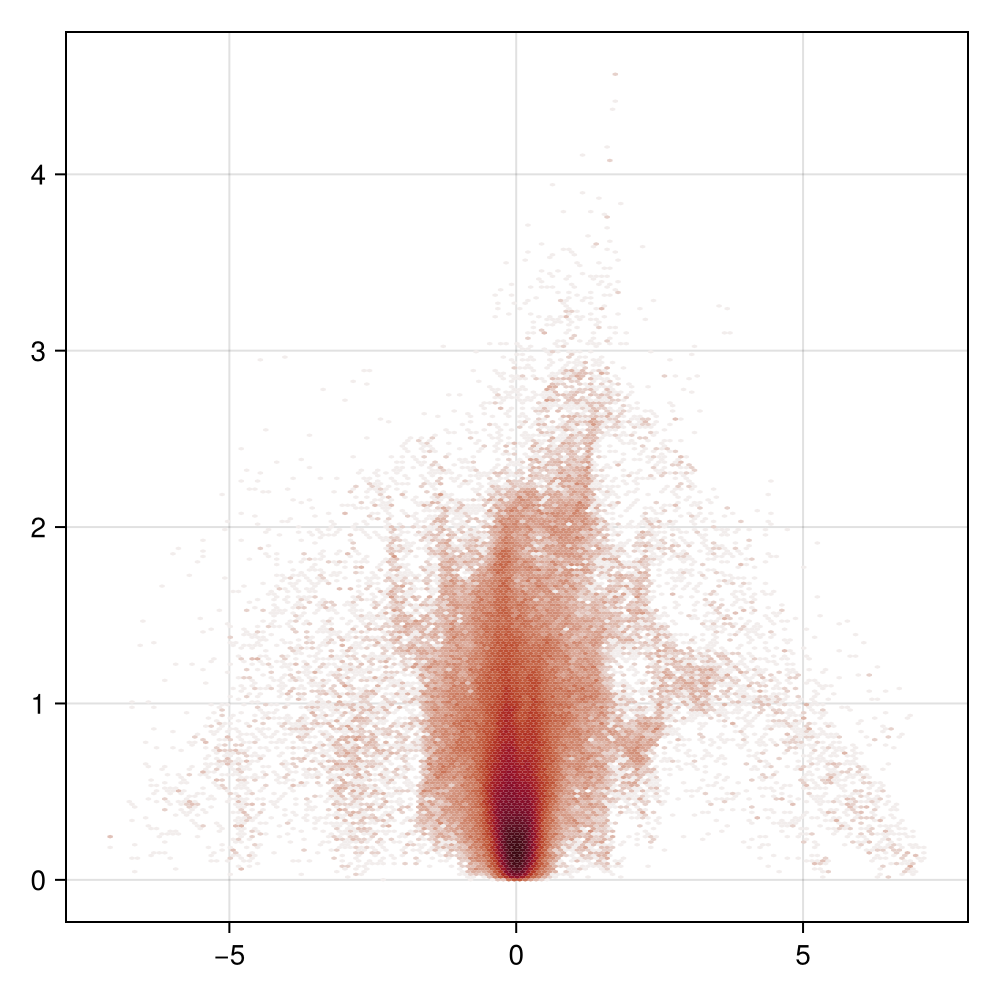

In [56]:
vort_strain_fig = Figure(size=(500, 500))
ax = Axis(vort_strain_fig[1,1])
#points = [Point2f(ζ[i], σ[i]) for i=1:(512*512)]
hexbin!(ax, ζ_array, σ_array, bins=300, colorscale=log10,colormap=:amp)
#scatter!(ax, ζ[:], σ[:])
#datashader!(ax, points)
vort_strain_fig

In [13]:
# Compute just for snapshot 100

idx = 2
t_snap = qg_snapshots["snapshots/t/" * frames[idx]]
qh = qg_snapshots["snapshots/sol/" * frames[idx]]
ψh = zeros(Complex{Float32}, size(qh))
streamfunctionfrompv!(ψh, qh, grid, params)
σ, ζ = compute_strain_vorticity(ψh)

([0.16866611161900852 0.16363369952242718 … 0.15889564142554977 0.1704246097359612; 0.1030082048871461 0.14113918503510953 … 0.18335324822160315 0.12350363653085217; … ; 0.1991495828596945 0.2440154009112126 … 0.23644659108653182 0.21066711637683722; 0.1645096850808145 0.16924205236163345 … 0.17207834173539016 0.18800783372148194], [-0.11140313984944224 -0.005034957427101548 … -0.11561919425327613 -0.21683668615124357; -0.08892294166947656 0.024603136913836865 … -0.12133707137746275 -0.2286008547247539; … ; -0.2789630487218259 -0.1706505596059522 … -0.1710072036102105 -0.30412854266808015; -0.125986119570849 -0.043590557492448674 … -0.054823916904491364 -0.16623086807457632])

6.894570592432777
2.178040567360676


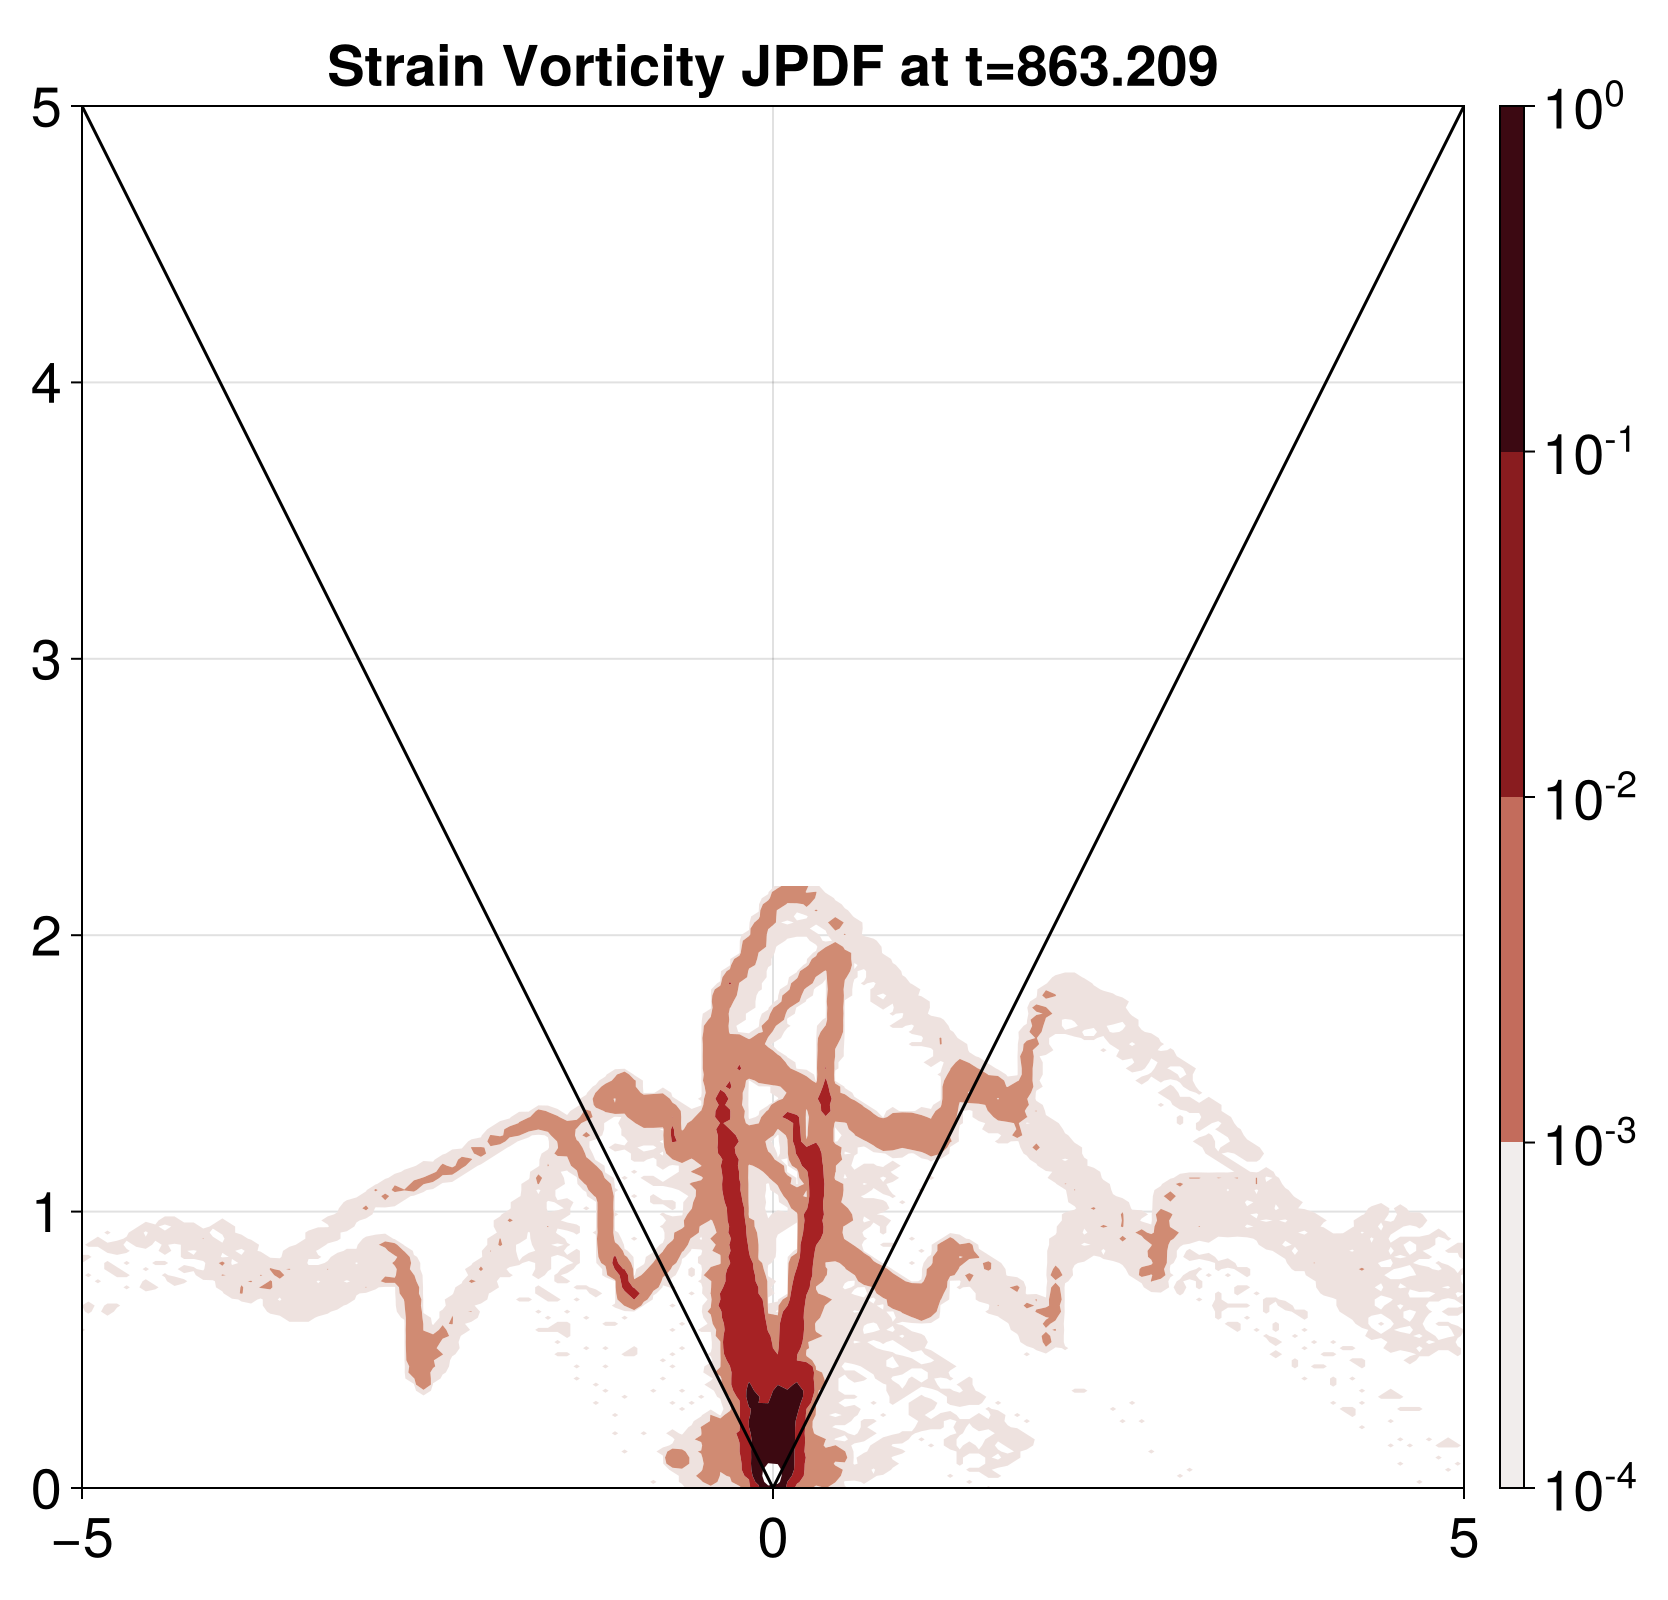

In [96]:
ζ_bins = 200
σ_bins = 100
max_ζ = maximum(abs.(ζ))
max_σ = maximum(σ)
max_limit = 5 #max(max_ζ, max_σ)
println(max_ζ)
println(max_σ)
bin_counts = zeros(ζ_bins, σ_bins)
ζ_idx = min.(floor.(Int, (ζ .+ max_ζ) / (2 * max_ζ) * ζ_bins) .+ 1, ζ_bins)
σ_idx = min.(floor.(Int, σ / max_σ * σ_bins) .+ 1, σ_bins)
for x_idx=1:grid.nx
    for y_idx=1:grid.ny
        bin_counts[ζ_idx[x_idx, y_idx], σ_idx[x_idx, y_idx]] += grid.dx * grid.dy
    end
end

ζ_vals = (0:(ζ_bins-1))/(ζ_bins-1) * 2 * max_ζ .- max_ζ
σ_vals = (0:(σ_bins-1))/(σ_bins-1) * max_σ

f = Figure(size=(800, 800), fontsize=28)
ax = Axis(f[1,1]; title=@sprintf("Strain Vorticity JPDF at t=%0.3f", t_snap),
    limits=((-max_limit, max_limit), (0, max_limit)))
ctr = contourf!(ax, ζ_vals, σ_vals,  bin_counts, 
    levels = 10.0.^(-4:0),
    colormap=:amp, colorscale=log10)
colsize!(f.layout, 1, Aspect(1,1.0))
ablines!(ax, [0, 0], [1, -1], color=:black)
cbar = Colorbar(f[1,2], ctr, ticks=10. .^(-4:0), 
    tickformat=values -> [rich("10", superscript(string(Int(log10(value)))))  for value in values])
resize_to_layout!(f)
save(@sprintf("strain_vorticity_jpdf_idx=%d.png", idx), f)
f

In [89]:
sum((1 .< σ) .* (abs.(ζ) .> 1))

10227

In [41]:
println(sqrt.(sum(ζ.^2)/(512*512)))
println(sqrt.(sum(σ.^2)/(512*512)))

0.5172684942428609
0.5172684942428609
